## MLP

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H = relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2


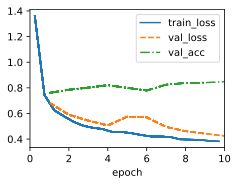

In [4]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

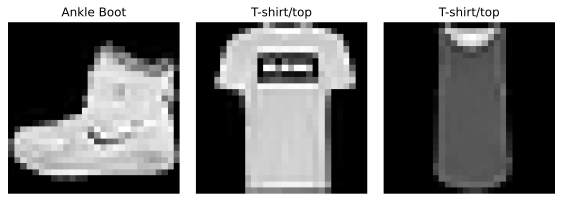

In [13]:
import matplotlib.pyplot as plt

def plot_samples(dataset, num_samples=3):
    plt.figure(figsize=(8, 8))
    labels_map = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
    ]
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.squeeze(0)  # Remove the channel dimension
        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(labels_map[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


plot_samples(data.train)

In [14]:
## Consise IMplementation

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

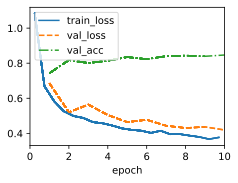

In [15]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Layers and Modules

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand(2, 20)
net(X).shape

/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 10])

In [3]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))
    
net = MLP()
net(X).shape

torch.Size([2, 10])

In [4]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # _init__ method, we add every module by calling the add_modules method. These modules can be accessed by the children method at a later date.
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

## Parameter management

In [6]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [7]:
# first access any layer by indexing into the model as though it were a list. Each layer’s parameters are conveniently located in its attribute.
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.1334,  0.1963,  0.1492, -0.1999,  0.0428, -0.2609, -0.3268, -0.0723]])),
             ('bias', tensor([0.2393]))])

In [8]:
# each parameter is represented as an instance of the parameter class. To do anything useful with the parameters, we first need to access the underlying numerical values. There are several ways to do this. Some are simpler while others are more general. 
# The following code extracts the bias from the second neural network layer, which returns a parameter class instance, and further accesses that parameter’s value.
type(net[2].bias), net[2].bias.data

(torch.nn.parameter.Parameter, tensor([0.2393]))

In [9]:
net[2].weight.grad == None

True

In [10]:
# all parameters 
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

In [11]:
# share params

# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


## Parameter Initialization


In [15]:
# By default, PyTorch initializes weight and bias matrices uniformly by drawing from a range that is computed according to the input and output dimension. 
# PyTorch’s nn.init module provides a variety of preset initialization methods.

def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0105, -0.0057, -0.0010,  0.0027]), tensor(0.))

In [16]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [18]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data)
print(net[2].weight.data)

tensor([[ 0.2020,  0.4416, -0.2296,  0.2635],
        [ 0.5592, -0.2933, -0.2538,  0.3016],
        [ 0.1697, -0.2176,  0.1972,  0.3908],
        [ 0.4045, -0.5414,  0.0746,  0.2091],
        [ 0.3531, -0.2614, -0.6435,  0.5490],
        [ 0.2774, -0.2530, -0.2029, -0.4496],
        [ 0.2634,  0.0884, -0.2046, -0.3242],
        [-0.6758, -0.3667,  0.5071, -0.6538]])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


In [19]:
# customized initialization
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-0.0000, 8.6806, 0.0000, 0.0000],
        [8.3042, 0.0000, 7.9735, 8.5722]], grad_fn=<SliceBackward0>)

## Lazy Initialization

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net[0].weight

/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<UninitializedParameter>

In [22]:
net[0].weight

<UninitializedParameter>

In [23]:
@d2l.add_to_class(d2l.Module)  #@save
def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

## Customized Layers

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [26]:
# without Paramereres
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()
    
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [27]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-5.5879e-09, grad_fn=<MeanBackward0>)

In [29]:
# Layers with Parmeters
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-0.8714, -0.1779, -1.4437],
        [ 0.3071,  0.2121, -0.1676],
        [-0.9316,  1.5002, -0.4910],
        [ 0.1179,  0.1391, -0.5312],
        [-1.3660, -0.2848, -0.0914]], requires_grad=True)

In [30]:
linear(torch.rand(2, 5))

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [31]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[2.5014],
        [6.4561]])

## File I/O

In [34]:
# load and save tensors
x = torch.arange(4)
torch.save(x, 'x-file')

x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [35]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [36]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

In [37]:
# saving paramerers 
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.output = nn.LazyLinear(10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)
torch.save(net.state_dict(), 'mlp.params')

/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [39]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [40]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

## GPUs 

In [42]:
#In PyTorch, the CPU and GPU can be indicated by torch.device('cpu') and torch.device('cuda'). It should be noted that the cpu device means all physical CPUs and memory. This means that PyTorch’s calculations will try to use all CPU cores. However, a gpu device only represents one card and the corresponding memory. If there are multiple GPUs, we use torch.device(f'cuda:{i}') to represent the 
# GPU (starts at 0). Also, gpu:0 and gpu are equivalent.

def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [43]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

0

In [45]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cpu'), device(type='cpu'), [])

In [48]:
# tensors on GPU 

x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

In [49]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [50]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.2362, 0.6641, 0.2220],
        [0.0201, 0.8187, 0.9402]])

In [51]:
# copying
# we can transfer X to the second GPU and perform the operation there. Do not simply add X and Y, since this will result in an exception. The runtime engine would not know what to do: it cannot find data on the same device and it fails. 
# Since Y lives on the second GPU, we need to move X there before we can add the two.
Z = X.cuda(1)
print(X)
print(Z)


AssertionError: Torch not compiled with CUDA enabled

In [52]:
Y + Z
Z.cuda(1) is Z

NameError: name 'Z' is not defined

In [53]:
## Neural Network on GPU

net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device=try_gpu())
net(X)

tensor([[0.3050],
        [0.3050]], grad_fn=<AddmmBackward0>)

In [54]:
net[0].weight.data.device

device(type='cpu')

In [ ]:
## Add GPU Capabilities
@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model